In [2]:
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [34]:
class MyCnn(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCnn, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.classifier = nn.Linear(256, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [35]:
def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    return {'train': train_loader, 'test': test_loader}

In [36]:
num_epoch = 1
history = {
    'train_loss':[],
    'test_loss':[],
    'test_acc':[]
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MyCnn().to(device)
loaders = load_MNIST()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

In [37]:
for i_epoch in range(num_epoch):
    loss = None
    
    net.train(True)
    
    for i, (data, target) in enumerate(loaders['train']):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        loss = f.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(i_epoch+1, (i+1)*128, loss.item()))
    
    history['train_loss'].append(loss)
    
    net.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= 10000
    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss, correct / 10000))
    
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)

Training log: 1 epoch (128 / 60000 train. data). Loss: -0.024080762639641762
Training log: 1 epoch (1408 / 60000 train. data). Loss: -3.4093551635742188
Training log: 1 epoch (2688 / 60000 train. data). Loss: -185.54656982421875
Training log: 1 epoch (3968 / 60000 train. data). Loss: -3139.251708984375
Training log: 1 epoch (5248 / 60000 train. data). Loss: -29544.203125
Training log: 1 epoch (6528 / 60000 train. data). Loss: -181777.0625
Training log: 1 epoch (7808 / 60000 train. data). Loss: -851819.5
Training log: 1 epoch (9088 / 60000 train. data). Loss: -3357213.75
Training log: 1 epoch (10368 / 60000 train. data). Loss: -10669662.0
Training log: 1 epoch (11648 / 60000 train. data). Loss: -29444318.0
Training log: 1 epoch (12928 / 60000 train. data). Loss: -72063584.0
Training log: 1 epoch (14208 / 60000 train. data). Loss: -172598544.0
Training log: 1 epoch (15488 / 60000 train. data). Loss: -358723872.0
Training log: 1 epoch (16768 / 60000 train. data). Loss: -714956352.0
Traini

{'train_loss': [tensor(-1.5555e+13, device='cuda:0', grad_fn=<NllLossBackward>)], 'test_loss': [-15490067830774.17], 'test_acc': [0.098]}


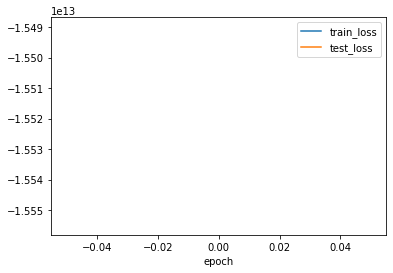

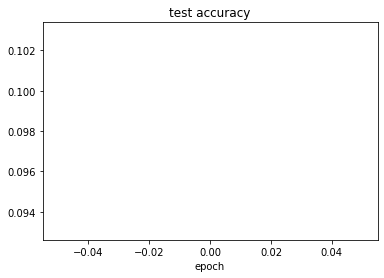

In [38]:
num_epoch
print(history)
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='train_loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('cnnloss.png')

plt.figure()
plt.plot(range(len(history['test_acc'])), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('cnn_test_acc2.png')